In [1]:
"""
- Build a way to produce place fields maps from the frame behavior data. I want this so my place field predictions can be properly cross-validated
and also because generally I want a faster pipeline to make place fields that isn't so obtuse. 

- Create a well-behaved interface for accepting a session & and returning a prediction for target activity given a particular model (named by string). 
  The idea would be to have something like predict_target(session, model_name) and it'll dispatch to the appropriate function whether it's the PF prediction,
  optimized prediction, RRR, etc etc. I'm guessing each one will have a nice cache since it'll probably take a long time to compute some of these models,
  especially where hyperparameters are involved. But if I can build a nice clear interface it'll be easier to add models and extend analyses on existing ones. 

    - I'm working on this in "model_pipeline.py" and supported code.
"""
print("Bad docstring!")

Bad docstring!


In [1]:
%reload_ext autoreload
%autoreload 2

import random
import numpy as np
from matplotlib import pyplot as plt
from syd import make_viewer
from tqdm import tqdm

from vrAnalysis.database import get_database
from vrAnalysis.helpers import Timer, get_placefield_location, cross_validate_trials, sort_by_preferred_environment
from vrAnalysis.sessions import B2Session
from vrAnalysis.processors import SpkmapProcessor
from vrAnalysis.processors.support import median_zscore
from vrAnalysis.processors.placefields import get_placefield, get_frame_behavior, get_placefield_prediction
from dimensionality_manuscript.regression_models.registry import PopulationRegistry, get_model
from dimensionality_manuscript.regression_models.hyperparameters import PlaceFieldHyperparameters, ReducedRankRegressionHyperparameters

sessiondb = get_database("vrSessions")

In [3]:
# gain models have nan predictions!!!!!
registry = PopulationRegistry()
ext_model = get_model("external_placefield_1d", registry)
int_model = get_model("internal_placefield_1d", registry)
ext_gain_model = get_model("external_placefield_1d_gain", registry)
int_gain_model = get_model("internal_placefield_1d_gain", registry)
rrr_model = get_model("rrr", registry)

In [7]:
session = B2Session.create("ATL012", "2023-01-20", "702")
r2 = int_model.score(session, reduce="mean")

In [ ]:
session = B2Session.create("ATL012", "2023-01-20", "702")
hyperparameters = ReducedRankRegressionHyperparameters(rank=200, alpha=1e1)
rrr_model.score(session, reduce="mean", hyperparameters=hyperparameters)
# rrr_model.autosave = False
# prms, score, results = rrr_model._optimize_grid(session, session.spks_type, train_split="train", validation_split="validation", hyperparameters=hyperparameters)

tensor(0.6544)

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 200)

# results

In [5]:
ext_gain_model.score(session, reduce="mean")

tensor(-0.0487, dtype=torch.float64)

In [9]:
spks_type = "significant"
ises = sessiondb.iter_sessions(session_params=dict(spks_type=spks_type), imaging=True)
for ses in ises:
    r2 = external_model.score(ses, reduce="mean")

In [3]:
spks_type = "significant"
ises = sessiondb.iter_sessions(session_params=dict(spks_type=spks_type), imaging=True, mouseName="ATL027")
session = ises[10] # random.choice(ises)
print(session.session_print())

ATL027/2023-08-04/702


In [10]:
spks_type = "significant"
ises = sessiondb.iter_sessions(session_params=dict(spks_type=spks_type), imaging=True, mouseName="ATL027")
session = ises[10] # random.choice(ises)
# r2i = internal_model.score(session, reduce="mean")
# r2e = external_model.score(session, reduce="mean")
with Timer("ext_gain_model.score"):
    r2eg = ext_gain_model.score(session, reduce="mean")

ext_gain_model.score || elapsed time: 2.8195 seconds


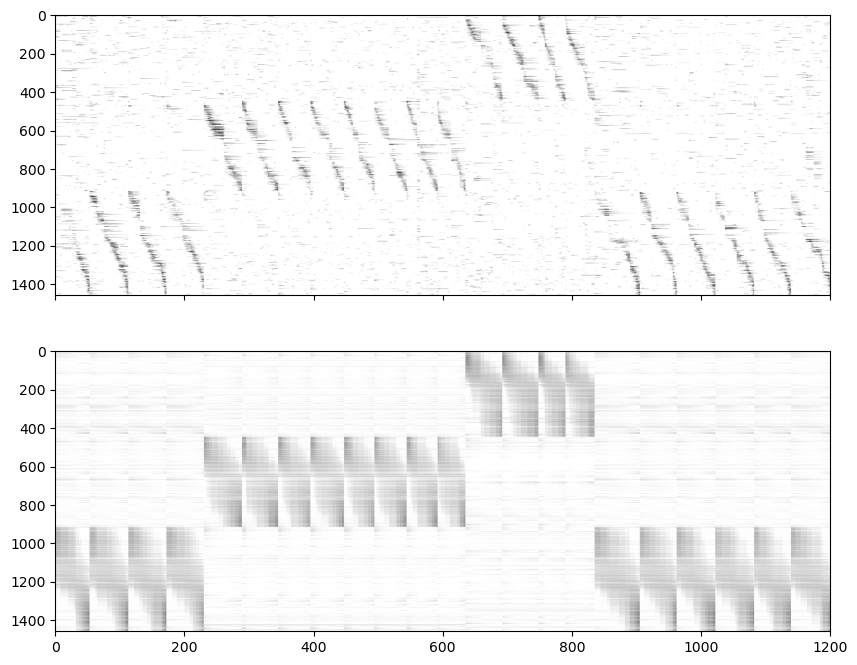

In [ ]:
split = "full"
population, frame_behavior = registry.get_population(session)
idx_split = population.get_split_times(registry.time_split[split], within_idx_samples=False)
frame_behavior_split = frame_behavior.filter(idx_split)
target_data = population.get_split_data(registry.time_split[split])[1]
trained_model = model.train(session)
predicted_data, _ = model.predict(session, trained_model, spks_type, split=split)

target_data = median_zscore(target_data.T.numpy()).T
predicted_data = median_zscore(predicted_data.T).T

idx_target = registry.get_population(session)[0].get_split_cells("target", within_idx_neurons=False)
idx_reliable = np.any(SpkmapProcessor(session).get_reliability().values[:, idx_target] > 0.7, axis=0)

idx_sort = sort_by_preferred_environment(SpkmapProcessor(session), idx_rois=idx_target[idx_reliable])

plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].imshow(target_data[idx_reliable][idx_sort], aspect="auto", vmin=0, vmax=10, cmap="gray_r")
ax[1].imshow(predicted_data[idx_reliable][idx_sort], aspect="auto", vmin=0, vmax=10, cmap="gray_r")
ax[1].set_xlim(0, 1200)
# ax[1].set_ylim(1900, 1700)
plt.show()

(3, 3608) torch.Size([3608])


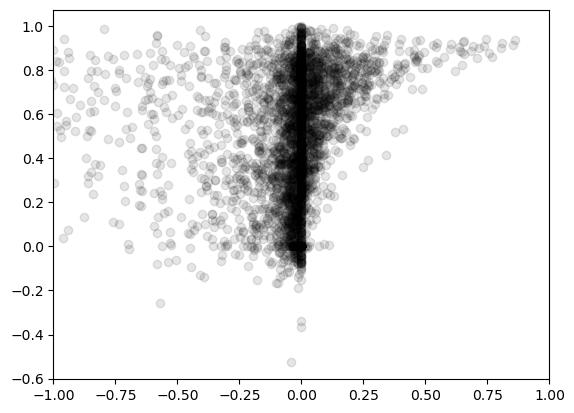

In [88]:
idx_target = registry.get_population(session)[0].get_split_cells("target", within_idx_neurons=False)
reliability = SpkmapProcessor(session).get_reliability().values[:, idx_target]
print(reliability.shape, r2s.shape)

plt.close('all')
plt.scatter(r2s.numpy(), np.max(reliability, axis=0), alpha=0.1, c='k')
plt.xlim(-1.0, 1.0)
plt.show()

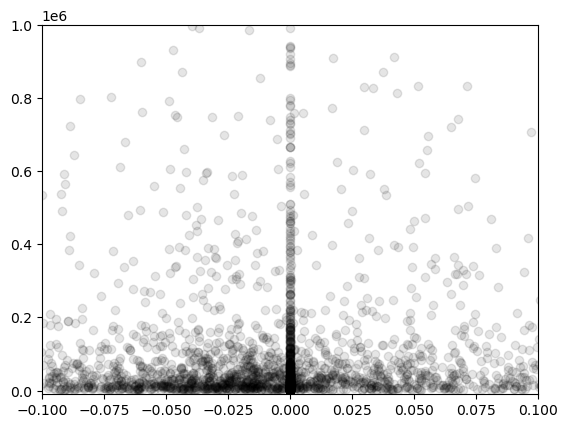

In [77]:
idx_r2s_zero = np.where(r2s.numpy() == 0.0)[0]
target_data.numpy().shape, r2s.shape

plt.close('all')
plt.scatter(r2s.numpy(), np.var(target_data.numpy(), axis=1), alpha=0.1, c='k')
plt.xlim(-0.1, 0.1)
plt.ylim(-1e4, 1e6)
plt.show()

In [ ]:
spks_type = "significant"
ises = sessiondb.iter_sessions(session_params=dict(spks_type=spks_type), imaging=True, mouseName="ATL027")
session = random.choice(ises)
session.session_print()

npop = registry.get_population(session, spks_type)[0]
idx_train = np.array(npop.get_split_times(registry.time_split.train))
idx_test = np.array(npop.get_split_times(registry.time_split.test))

idx_train_bool = np.zeros(npop.num_timepoints, dtype=bool)
idx_test_bool = np.zeros(npop.num_timepoints, dtype=bool)
idx_train_bool[idx_train] = True
idx_test_bool[idx_test] = True

In [ ]:
spks = session.spks[:, session.idx_rois]
zspks = median_zscore(spks)
dist_edges = np.linspace(0, 200, 201)
speed_threshold = 1.0

frame_behavior = get_frame_behavior(session, clear_one_cache=True)
idx_valid_frames = frame_behavior.valid_frames()

frame_behavior_train = frame_behavior.filter(idx_train_bool & idx_valid_frames)
frame_behavior_test = frame_behavior.filter(idx_test_bool & idx_valid_frames)
idx_to_spks_train = np.where(idx_train_bool & idx_valid_frames)[0]
idx_to_spks_test = np.where(idx_test_bool & idx_valid_frames)[0]

placefield_train = get_placefield(zspks, frame_behavior_train, dist_edges, speed_threshold=speed_threshold, average=True, idx_to_spks=idx_to_spks_train)
placefield_test = get_placefield(zspks, frame_behavior_test, dist_edges, speed_threshold=speed_threshold, average=True, idx_to_spks=idx_to_spks_test)

In [29]:
pfpred_noncv, extras_noncv = get_placefield_prediction(placefield_test, frame_behavior_test)
pfpred, extras = get_placefield_prediction(placefield_train, frame_behavior_test)
zspks_test = zspks[idx_to_spks_test]